In [1]:
import fitsio
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy import stats

In [2]:
import lib

In [3]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [4]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

In [5]:
fits = fitsio.FITS("/global/cfs/cdirs/des/y6-shear-catalogs/y6a2_piff_v3_HOMSs_v1_unique.fits")

In [6]:
d = fits[1].read()

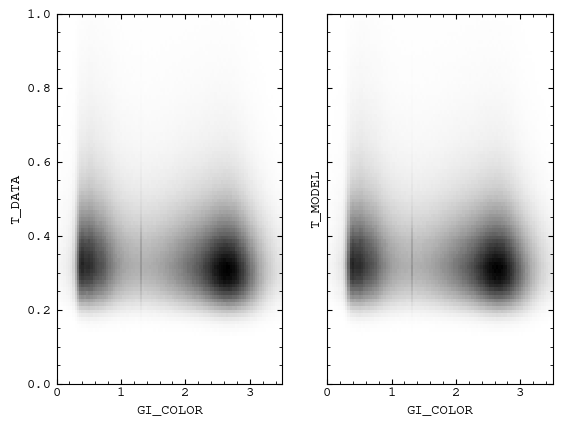

In [7]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].hist2d(
    d["GI_COLOR"],
    d["T_DATA"],
    (np.linspace(0, 3.5, 101), np.linspace(0, 1, 101)),
)
axs[1].hist2d(
    d["GI_COLOR"],
    d["T_MODEL"],
    (np.linspace(0, 3.5, 101), np.linspace(0, 1, 101)),
)
axs[0].set_xlabel("GI_COLOR")
axs[1].set_xlabel("GI_COLOR")

axs[0].set_ylabel("T_DATA")
axs[1].set_ylabel("T_MODEL")

plt.show()

In [26]:
TvsGI_bins = np.linspace(0, 3.5, 101)
TvsGI_centers = 0.5 * (TvsGI_bins[:-1] + TvsGI_bins[1:])
TvsGI, _, _ = stats.binned_statistic(
    d["GI_COLOR"],
    d["T_MODEL"],
    statistic="median",
    bins=TvsGI_bins,
)

In [9]:
# i = np.digitize(lib.const.GI_COLOR, TvsGI_bins)

In [28]:
p = np.polynomial.Polynomial.fit(TvsGI_centers, TvsGI, deg=1)
# p = np.polynomial.Polynomial.fit(
#     d["GI_COLOR"],
#     d["T_MODEL"],
#     deg=1,
# )

In [29]:
p_deriv = p.deriv(1)

In [30]:
T_GI_COLOR = p(lib.const.GI_COLOR)

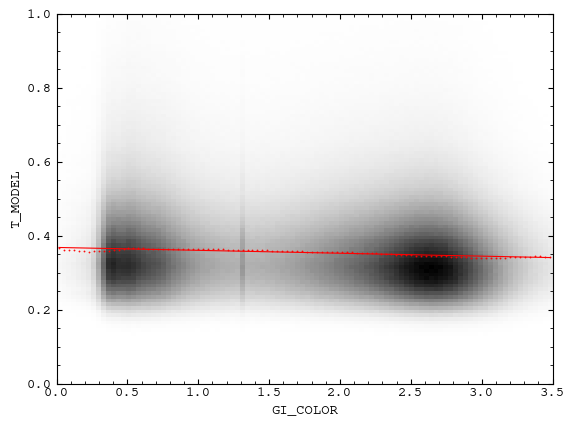

In [31]:
plt.hist2d(
    d["GI_COLOR"],
    d["T_MODEL"],
    (np.linspace(0, 3.5, 101), np.linspace(0, 1, 101)),
)
plt.scatter(TvsGI_centers, TvsGI, c="r")
plt.plot(TvsGI_centers, p(TvsGI_centers), c="r")
plt.xlabel("GI_COLOR")
plt.ylabel("T_MODEL")
plt.show()

In [14]:
def sum_of_squares(xs):
    return np.sum(np.square(xs))

In [27]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
):
    flux_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    flux_err_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    flux_err_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_plus = lib.util.flux_to_mag(flux_g_plus) - lib.util.flux_to_mag(flux_i_plus)
    mag_g_plus, mag_err_g_plus = lib.util.flux_to_mag_with_error(flux_g_plus, flux_err_g_plus)
    mag_i_plus, mag_err_i_plus = lib.util.flux_to_mag_with_error(flux_i_plus, flux_err_i_plus)
    color_plus = mag_g_plus - mag_i_plus
    color_err_plus = np.sqrt(np.square(mag_err_g_plus) + np.square(mag_err_i_plus))

    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    gal_T_plus = shear_plus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_plus["mdet"]["noshear"]["gauss_psf_T"][:]
    gal_T_err_plus = shear_plus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_plus = p(color_plus)
    psf_T_err_plus = p_deriv(color_plus) * color_err_plus

    m_plus = -(psf_T_plus - T_GI_COLOR) / gal_T_plus
    # m_err_plus = psf_T_err_plus / gal_T_plus
    m_err_plus = np.sqrt(np.square(psf_T_err_plus / gal_T_plus) + np.square((psf_T_plus - T_GI_COLOR) / np.square(gal_T_plus) * gal_T_err_plus))

    flux_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    flux_err_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    flux_err_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_minus = lib.util.flux_to_mag(flux_g_minus) - lib.util.flux_to_mag(flux_i_minus)
    mag_g_minus, mag_err_g_minus = lib.util.flux_to_mag_with_error(flux_g_minus, flux_err_g_minus)
    mag_i_minus, mag_err_i_minus = lib.util.flux_to_mag_with_error(flux_i_minus, flux_err_i_minus)
    color_minus = mag_g_minus - mag_i_minus
    color_err_minus = np.sqrt(np.square(mag_err_g_minus) + np.square(mag_err_i_minus))
        
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    gal_T_minus = shear_minus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_minus["mdet"]["noshear"]["gauss_psf_T"][:]
    gal_T_err_minus = shear_minus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_minus = p(color_minus)
    psf_T_err_minus = p_deriv(color_minus) * color_err_minus

    m_minus = -(psf_T_minus - T_GI_COLOR) / gal_T_minus
    # m_err_minus = psf_T_err_minus / gal_T_minus
    m_err_minus = np.sqrt(np.square(psf_T_err_minus / gal_T_minus) + np.square((psf_T_minus - T_GI_COLOR) / np.square(gal_T_minus) * gal_T_err_minus))

    count_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        None,
        statistic="count",
        bins=bins,
    )
    mean_color_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        color_plus,
        statistic="mean",
        bins=bins,
    )
    std_color_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        color_plus,
        statistic="std",
        bins=bins,
    )
    mean_size_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        psf_T_plus,
        statistic="mean",
        bins=bins,
    )
    std_size_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        psf_T_plus,
        statistic="std",
        bins=bins,
    )
    mean_m_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        m_plus,
        statistic="mean",
        bins=bins,
    )
    std_m_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        m_plus,
        statistic="std",
        bins=bins,
    )

    count_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        None,
        statistic="count",
        bins=bins,
    )        
    mean_color_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        color_minus,
        statistic="mean",
        bins=bins,
    )
    std_color_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        color_minus,
        statistic="std",
        bins=bins,
    )
    mean_size_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        psf_T_minus,
        statistic="mean",
        bins=bins,
    )
    std_size_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        psf_T_minus,
        statistic="std",
        bins=bins,
    )
    mean_m_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        m_minus,
        statistic="mean",
        bins=bins,
    )
    std_m_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        m_minus,
        statistic="std",
        bins=bins,
    )

count_sim = 0.5 * (count_plus + count_minus)

mean_color_sim = 0.5 * (mean_color_plus + mean_color_minus)
std_color_sim = 0.5 * (std_color_plus / np.sqrt(count_plus) + std_color_minus / np.sqrt(count_minus))
# std_color_sim = 0.5 * (std_color_plus + std_color_minus)

mean_size_sim = 0.5 * (mean_size_plus + mean_size_minus)
std_size_sim = 0.5 * (std_size_plus / np.sqrt(count_plus) + std_size_minus / np.sqrt(count_minus))
# std_size_sim = 0.5 * (std_size_plus + std_size_minus)

mean_m_sim = 0.5 * (mean_m_plus + mean_m_minus)
std_m_sim = 0.5 * (std_m_plus / np.sqrt(count_plus) + std_m_minus / np.sqrt(count_minus))
# std_m_sim = 0.5 * (std_m_plus + std_m_minus)

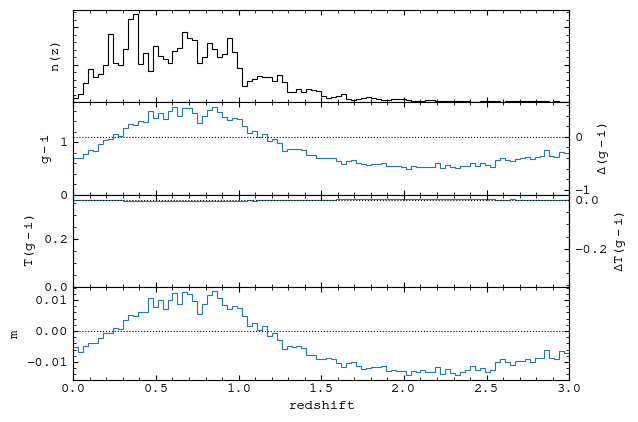

In [35]:
fig, axs = plt.subplots(4, 1, sharex=True)

fig.subplots_adjust(hspace=0)

axs[0].stairs(count_sim, bins, ec="k")

axs[1].axhline(lib.const.GI_COLOR, ls=":")
# axs[1].errorbar(centers, mean_color_sim, std_color_sim, fmt="o", c="k")
# axs[1].plot(centers, mean_color_sim)
axs[1].stairs(mean_color_sim, bins)

_axs1 = axs[1].secondary_yaxis(
    "right",
    functions=(
        lambda x: x - lib.const.GI_COLOR,
        lambda x: x + lib.const.GI_COLOR,
    ),
)

axs[2].axhline(p(lib.const.GI_COLOR), ls=":")
# axs[2].errorbar(centers, mean_size_sim, std_size_sim, fmt="o", c="k")
# axs[2].plot(centers, mean_size_sim)
axs[2].stairs(mean_size_sim, bins)

_axs2 = axs[2].secondary_yaxis(
    "right",
    functions=(
        lambda x: x - T_GI_COLOR,
        lambda x: x + T_GI_COLOR,
    ),
)

axs[3].axhline(0, ls=":")
# axs[3].errorbar(centers, mean_m_sim, std_m_sim, fmt="o", c="k")
# axs[3].plot(centers, mean_m_sim)
axs[3].stairs(mean_m_sim, bins)


# axs[4].stairs(count_sim * (1 + mean_m_sim - error_m_sim), bins, ec="k", ls=":")
# axs[4].stairs(count_sim * (1 + mean_m_sim + error_m_sim), bins, ec="k", ls=":")
# axs[4].stairs(count_sim * (1 + mean_m_sim), bins, ec="k")

axs[-1].set_xlabel("redshift")
axs[-1].set_xlim(0, 3)
axs[0].set_yticklabels([])
axs[0].set_ylabel("$n(z)$")
axs[1].set_ylabel(f"$g - i$")
axs[1].tick_params(axis="y", which="both", right=False)
_axs1.set_ylabel("$\\Delta (g - i)$")
axs[2].set_ylabel("$T(g - i)$")
axs[2].tick_params(axis="y", which="both", right=False)
_axs2.set_ylabel("$\\Delta T(g - i)$")
axs[3].set_ylabel("$m$")

plt.show()

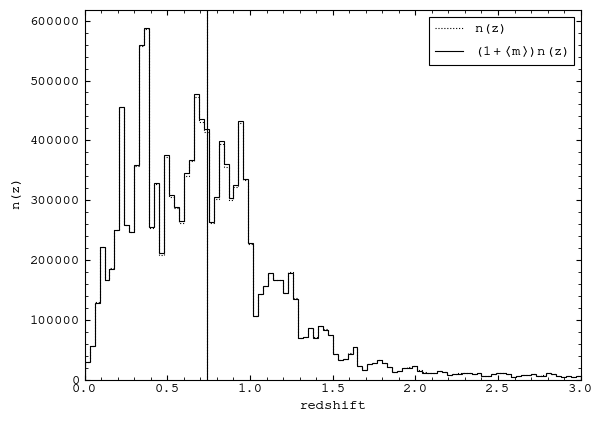

In [36]:
fig, axs = plt.subplots(1, 1)

axs.axvline(np.average(centers, weights=count_sim), ls=":")
axs.stairs(count_sim, bins, ec="k", ls=":", label="$n(z)$")

axs.axvline(np.average(centers, weights=(1 + mean_m_sim) * count_sim))
axs.stairs((1 + mean_m_sim) * count_sim, bins, ec="k", label="$(1 + 〈m〉) n(z)$")

axs.set_xlabel("redshift")
axs.set_xlim(0, 3)
axs.set_ylabel("$n(z)$")
axs.legend(loc="upper right")

plt.show()

In [52]:
NBINS = 10
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

count_sim = {}
mean_color_sim = {}
error_color_sim = {}
# std_color_sim = {}
mean_size_sim = {}
error_size_sim = {}
# std_size_sim = {}
mean_m_sim = {}
error_m_sim = {}
# std_m_sim = {}
tomo_mean_m_sim = {}
tomo_error_m_sim = {}
# tomo_std_m_sim = {}
tomo_mean_dz_sim = {}
tomo_error_dz_sim = {}
# tomo_std_dz_sim = {}

with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_plus]) as tomo_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_minus]) as tomo_minus,

):

    flux_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    # flux_err_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    # flux_err_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_plus = lib.util.flux_to_mag(flux_g_plus) - lib.util.flux_to_mag(flux_i_plus)
    mag_g_plus, mag_err_g_plus = lib.util.flux_to_mag_with_error(flux_g_plus, flux_err_g_plus)
    mag_i_plus, mag_err_i_plus = lib.util.flux_to_mag_with_error(flux_i_plus, flux_err_i_plus)
    color_plus = mag_g_plus - mag_i_plus
    # color_err_plus = np.sqrt(np.square(mag_err_g_plus) + np.square(mag_err_i_plus))

    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    gal_T_plus = shear_plus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_plus["mdet"]["noshear"]["gauss_psf_T"][:]
    # gal_T_err_plus = shear_plus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_plus = p(color_plus)
    # psf_T_err_plus = p_deriv(color_plus) * color_err_plus

    m_plus = -(psf_T_plus - T_GI_COLOR) / gal_T_plus
    # m_err_plus = psf_T_err_plus / gal_T_plus
    # m_err_plus = np.sqrt(np.square(psf_T_err_plus / gal_T_plus) + np.square((psf_T_plus - T_GI_COLOR) / np.square(gal_T_plus) * gal_T_err_plus))

    bhat_plus = tomo_plus["sompz"]["noshear"]["bhat"][:]

    flux_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    # flux_err_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    # flux_err_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_minus = lib.util.flux_to_mag(flux_g_minus) - lib.util.flux_to_mag(flux_i_minus)
    mag_g_minus, mag_err_g_minus = lib.util.flux_to_mag_with_error(flux_g_minus, flux_err_g_minus)
    mag_i_minus, mag_err_i_minus = lib.util.flux_to_mag_with_error(flux_i_minus, flux_err_i_minus)
    color_minus = mag_g_minus - mag_i_minus
    # color_err_minus = np.sqrt(np.square(mag_err_g_minus) + np.square(mag_err_i_minus))
        
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    gal_T_minus = shear_minus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_minus["mdet"]["noshear"]["gauss_psf_T"][:]
    # gal_T_err_minus = shear_minus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_minus = p(color_minus)
    # psf_T_err_minus = p_deriv(color_minus) * color_err_minus

    m_minus = -(psf_T_minus - T_GI_COLOR) / gal_T_minus
    # m_err_minus = psf_T_err_minus / gal_T_minus
    # m_err_minus = np.sqrt(np.square(psf_T_err_minus / gal_T_minus) + np.square((psf_T_minus - T_GI_COLOR) / np.square(gal_T_minus) * gal_T_err_minus))

    bhat_minus = tomo_minus["sompz"]["noshear"]["bhat"][:]

    # ---

    
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        in_tomo_plus = (bhat_plus == tomographic_bin)
        in_tomo_minus = (bhat_minus == tomographic_bin)

        _count_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            None,
            statistic="count",
            bins=bins,
        )
        _mean_color_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            color_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_color_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            color_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_color_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     color_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_size_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            psf_T_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_size_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            psf_T_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_size_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     psf_T_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_m_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            m_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_m_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            m_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_m_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     m_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
    
        _count_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            None,
            statistic="count",
            bins=bins,
        )        
        _mean_color_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            color_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_color_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            color_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_color_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     color_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_size_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            psf_T_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_size_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            psf_T_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_size_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     psf_T_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_m_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            m_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_m_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            m_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_m_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     m_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
  
        count_sim[tomographic_bin] = 0.5 * (_count_plus + _count_minus)

        mean_color_sim[tomographic_bin] = 0.5 * (_mean_color_plus + _mean_color_minus)
        error_color_sim[tomographic_bin] = 0.5 * (_std_color_plus / np.sqrt(_count_plus) + _std_color_minus / np.sqrt(_count_minus))
        # error_color_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_color_plus / _count_plus) + np.sqrt(_error_color_minus / _count_minus))

        mean_size_sim[tomographic_bin] = 0.5 * (_mean_size_plus + _mean_size_minus)
        error_size_sim[tomographic_bin] = 0.5 * (_std_size_plus / np.sqrt(_count_plus) + _std_size_minus / np.sqrt(_count_minus))
        # error_size_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_size_plus / _count_plus) + np.sqrt(_error_size_minus / _count_minus))

        mean_m_sim[tomographic_bin] = 0.5 * (_mean_m_plus + _mean_m_minus)
        error_m_sim[tomographic_bin] = 0.5 * (_std_m_plus / np.sqrt(_count_plus) + _std_m_minus / np.sqrt(_count_minus))
        # error_m_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_m_plus / _count_plus) + np.sqrt(_error_m_minus / _count_minus))

        _tomo_mean_m_plus = np.mean(_mean_m_plus)
        _tomo_error_m_plus = np.sqrt(np.sum(np.square(_std_m_plus)) / np.sum(in_tomo_plus))
    
        _tomo_mean_m_minus = np.mean(_mean_m_minus)
        _tomo_error_m_minus = np.sqrt(np.sum(np.square(_std_m_minus)) / np.sum(in_tomo_minus))

        _tomo_mean_dz_plus = np.average(
            redshift_plus[in_tomo_plus],
            weights=(1 + m_plus[in_tomo_plus]),
        ) - np.average(redshift_plus[in_tomo_plus])
        _tomo_error_dz_plus = np.std(m_plus[in_tomo_plus]) / np.sum(in_tomo_plus)
        
        _tomo_mean_dz_minus = np.average(
            redshift_minus[in_tomo_minus],
            weights=(1 + m_minus[in_tomo_minus]),
        ) - np.average(redshift_minus[in_tomo_minus])
        _tomo_error_dz_minus = np.std(m_minus[in_tomo_minus]) / np.sum(in_tomo_minus)
        
        tomo_mean_m_sim[tomographic_bin] = 0.5 * (_tomo_mean_m_plus + _tomo_mean_m_minus)
        tomo_error_m_sim[tomographic_bin] = 0.5 * (_tomo_error_m_plus + _tomo_error_m_minus)

        tomo_mean_dz_sim[tomographic_bin] = 0.5 * (_tomo_mean_dz_plus + _tomo_mean_dz_minus)
        tomo_error_dz_sim[tomographic_bin] = 0.5 * (_tomo_error_dz_plus + _tomo_error_dz_minus)


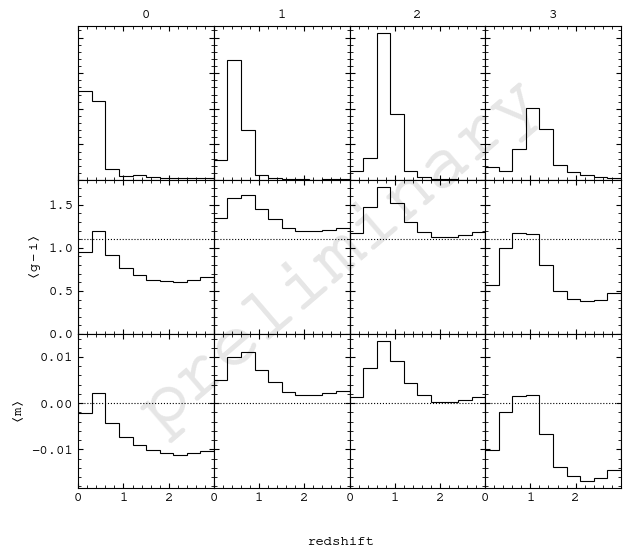

In [53]:
fig, axs = plt.subplots(3, 4, figsize=(7, 6), sharex=True, sharey="row")

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    axs[0, tomographic_bin].stairs(count_sim[tomographic_bin], bins, ec="k")
    
    axs[1, tomographic_bin].axhline(lib.const.GI_COLOR, ls=":")
    # axs[1, tomographic_bin].errorbar(centers, mean_color_sim[tomographic_bin], error_color_sim[tomographic_bin], fmt="o", c="k")
    axs[1, tomographic_bin].stairs(mean_color_sim[tomographic_bin], bins, ec="k")

    # axs[2, tomographic_bin].axhline(T_GI_COLOR, ls=":")
    # # axs[2, tomographic_bin].errorbar(centers, mean_size_sim[tomographic_bin], error_size_sim[tomographic_bin], fmt="o", c="k")
    # axs[2, tomographic_bin].stairs(mean_size_sim[tomographic_bin], bins, ec="k")

    axs[2, tomographic_bin].axhline(0, ls=":")
    # axs[3, tomographic_bin].errorbar(centers, mean_m_sim[tomographic_bin], error_m_sim[tomographic_bin], fmt="o", c="k")
    axs[2, tomographic_bin].stairs(mean_m_sim[tomographic_bin], bins, ec="k")

    axs[0, tomographic_bin].set_title(tomographic_bin)

fig.supxlabel("redshift")
axs[-1, -1].set_xlim(0, 3)
axs[-1, -1].set_xticks([0, 1, 2])
axs[0, 0].set_yticklabels([])
axs[1, 0].set_ylabel(f"$〈 g - i 〉$")
# axs[2, 0].set_ylabel("$〈 T(g - i) 〉$")
axs[2, 0].set_ylabel("$〈m〉$")

lib.plotting.watermark(fig)

fig.savefig("chromatic-bias.pdf")
plt.show()
    

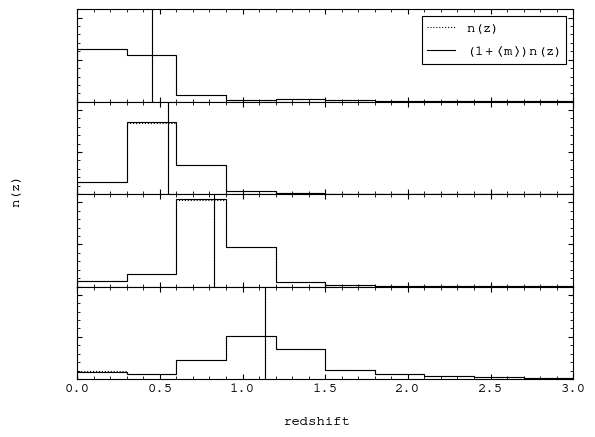

In [54]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    axs[tomographic_bin].axvline(np.average(centers, weights=count_sim[tomographic_bin]), ls=":")
    axs[tomographic_bin].stairs(count_sim[tomographic_bin], bins, ec="k", ls=":", label="$n(z)$")
    
    axs[tomographic_bin].axvline(np.average(centers, weights=(1 + mean_m_sim[tomographic_bin]) * count_sim[tomographic_bin]))
    axs[tomographic_bin].stairs((1 + mean_m_sim[tomographic_bin]) * count_sim[tomographic_bin], bins, ec="k", label="$(1 + 〈m〉) n(z)$")

fig.supxlabel("redshift")
axs[0].set_xlim(0, 3)
axs[0].set_yticklabels([])
fig.supylabel("$n(z)$")
axs[0].legend(loc="upper right")

plt.show()

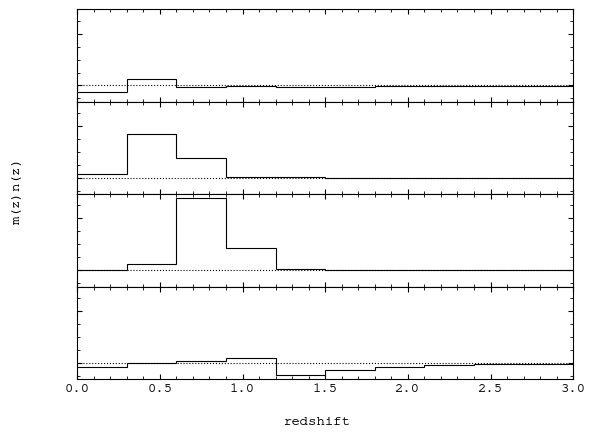

In [55]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    axs[tomographic_bin].axhline(0, ls=":")
    axs[tomographic_bin].stairs(mean_m_sim[tomographic_bin] * count_sim[tomographic_bin], bins, ec="k")

fig.supxlabel("redshift")
axs[0].set_xlim(0, 3)
axs[0].set_yticklabels([])
fig.supylabel("$m(z) n(z)$")

plt.show()

In [57]:
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{tomographic_bin}:"
        "\t"
        f"m = {tomo_mean_m_sim[tomographic_bin]:+7.4f} ± {tomo_error_m_sim[tomographic_bin]:6.8f}"
        "\t"
        f"dz = {tomo_mean_dz_sim[tomographic_bin]:+7.4f} ± {tomo_error_dz_sim[tomographic_bin]:6.8f}"
    )

0:	m = -0.0074 ± 0.00001432	dz = -0.0011 ± 0.00000000
1:	m = +0.0048 ± 0.00001666	dz = -0.0001 ± 0.00000000
2:	m = +0.0040 ± 0.00001752	dz = -0.0002 ± 0.00000000
3:	m = -0.0092 ± 0.00002218	dz = -0.0018 ± 0.00000001


In [60]:
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{tomographic_bin}:"
        "\t"
        f"m = {tomo_mean_m_sim[tomographic_bin] / 1e-3:+7.4f}"
        "\t"
        f"dz = {tomo_mean_dz_sim[tomographic_bin]:+7.4f}"
    )

0:	m = -7.3788	dz = -0.0011
1:	m = +4.8471	dz = -0.0001
2:	m = +4.0357	dz = -0.0002
3:	m = -9.2482	dz = -0.0018


---

In [208]:
NBINS = 10
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

count_plus = {}
mean_color_plus = {}
mean_size_plus = {}
mean_m_plus = {}
tomo_mean_m_plus = {}

count_minus = {}
mean_color_minus = {}
mean_size_minus = {}
mean_m_minus = {}
tomo_mean_m_minus = {}

count_sim = {}
mean_color_sim = {}
mean_size_sim = {}
mean_m_sim = {}
tomo_mean_m_sim = {}


with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_plus]) as tomo_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_minus]) as tomo_minus,

):
    tilename_plus = shear_plus["mdet"]["noshear"]["tilename"][:]
    tilename_minus = shear_minus["mdet"]["noshear"]["tilename"][:]
    _tilenames_p = np.unique(tilename_plus)
    _tilenames_m = np.unique(tilename_minus)
    tilenames = np.intersect1d(_tilenames_p, _tilenames_m)
    # tilenames = tilenames[:10]  # FIXME
    ntiles = len(tilenames)

    flux_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    color_plus = lib.util.flux_to_mag(flux_g_plus) - lib.util.flux_to_mag(flux_i_plus)
    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    gal_T_plus = shear_plus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_plus["mdet"]["noshear"]["gauss_psf_T"][:]
    psf_T_plus = p(color_plus)
    bhat_plus = tomo_plus["sompz"]["noshear"]["bhat"][:]

    flux_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    color_minus = lib.util.flux_to_mag(flux_g_minus) - lib.util.flux_to_mag(flux_i_minus)
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    gal_T_minus = shear_minus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_minus["mdet"]["noshear"]["gauss_psf_T"][:]
    psf_T_minus = p(color_minus)
    bhat_minus = tomo_minus["sompz"]["noshear"]["bhat"][:]

    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        count_plus[tomographic_bin] = []
        mean_color_plus[tomographic_bin] = []
        mean_size_plus[tomographic_bin] = []
        mean_m_plus[tomographic_bin] = []
        tomo_mean_m_plus[tomographic_bin] = []
        
        count_minus[tomographic_bin] = []
        mean_color_minus[tomographic_bin] = []
        mean_size_minus[tomographic_bin] = []
        mean_m_minus[tomographic_bin] = []
        tomo_mean_m_minus[tomographic_bin] = []
        
        in_tomo_plus = (bhat_plus == tomographic_bin)
        in_tomo_minus = (bhat_minus == tomographic_bin)

        for tile in tilenames:
            in_tile_plus = (tilename_plus == tile)
            in_tile_minus = (tilename_minus == tile)

            sel_plus = in_tomo_plus & in_tile_plus
            sel_minus = in_tomo_minus & in_tile_minus

            if (sum(sel_plus) == 0) | (sum(sel_minus) == 0):
                continue

            _count_plus, _, _ = stats.binned_statistic(
                redshift_plus[sel_plus],
                None,
                statistic="count",
                bins=bins,
            )
            _mean_color_plus, _, _ = stats.binned_statistic(
                redshift_plus[sel_plus],
                color_plus[sel_plus],
                statistic="mean",
                bins=bins,
            )
            _mean_size_plus, _, _ = stats.binned_statistic(
                redshift_plus[sel_plus],
                psf_T_plus[sel_plus],
                statistic="mean",
                bins=bins,
            )
            _mean_m_plus, _, _ = stats.binned_statistic(
                redshift_plus[sel_plus],
                -(psf_T_plus[sel_plus] - T_GI_COLOR) / gal_T_plus[sel_plus],
                statistic="mean",
                bins=bins,
            )
        
            _count_minus, _, _ = stats.binned_statistic(
                redshift_minus[sel_minus],
                None,
                statistic="count",
                bins=bins,
            )        
            _mean_color_minus, _, _ = stats.binned_statistic(
                redshift_minus[sel_minus],
                color_minus[sel_minus],
                statistic="mean",
                bins=bins,
            )
            _mean_size_minus, _, _ = stats.binned_statistic(
                redshift_minus[sel_minus],
                psf_T_minus[sel_minus],
                statistic="mean",
                bins=bins,
            )
            _mean_m_minus, _, _ = stats.binned_statistic(
                redshift_minus[sel_minus],
                -(psf_T_minus[sel_minus] - T_GI_COLOR) / gal_T_minus[sel_minus],
                statistic="mean",
                bins=bins,
            )

            _tomo_mean_m_plus = np.mean(
                -(psf_T_plus[sel_plus] - T_GI_COLOR) / gal_T_plus[sel_plus],
            )
            
            _tomo_mean_m_minus = np.mean(
                -(psf_T_minus[sel_minus] - T_GI_COLOR) / gal_T_minus[sel_minus],
            )

            count_plus[tomographic_bin].append(_count_plus)
            mean_color_plus[tomographic_bin].append(_mean_color_plus)
            mean_size_plus[tomographic_bin].append(_mean_size_plus)
            mean_m_plus[tomographic_bin].append(_mean_m_plus)
            tomo_mean_m_plus[tomographic_bin].append(_tomo_mean_m_plus)
            
            count_minus[tomographic_bin].append(_count_minus)
            mean_color_minus[tomographic_bin].append(_mean_color_minus)
            mean_size_minus[tomographic_bin].append(_mean_size_minus)
            mean_m_minus[tomographic_bin].append(_mean_m_minus)
            tomo_mean_m_minus[tomographic_bin].append(_tomo_mean_m_minus)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    count_plus[tomographic_bin] = np.array(count_plus[tomographic_bin])
    mean_color_plus[tomographic_bin] = np.array(mean_color_plus[tomographic_bin])
    mean_size_plus[tomographic_bin] = np.array(mean_size_plus[tomographic_bin])
    mean_m_plus[tomographic_bin] = np.array(mean_m_plus[tomographic_bin])
    tomo_mean_m_plus[tomographic_bin] = np.array(tomo_mean_m_plus[tomographic_bin])
    
    count_minus[tomographic_bin] = np.array(count_minus[tomographic_bin])
    mean_color_minus[tomographic_bin] = np.array(mean_color_minus[tomographic_bin])
    mean_size_minus[tomographic_bin] = np.array(mean_size_minus[tomographic_bin])
    mean_m_minus[tomographic_bin] = np.array(mean_m_minus[tomographic_bin])
    tomo_mean_m_minus[tomographic_bin] = np.array(tomo_mean_m_minus[tomographic_bin])


In [221]:
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    mean = np.nanmean(mean_m_plus[tomographic_bin], axis=0)
    
    n_jackknife = None
    
    if n_jackknife is None:
        n_jackknife = len(mean_m_plus[tomographic_bin])
    
    var = (n_jackknife - 1) / n_jackknife * np.nansum(
        (mean_m_plus[tomographic_bin] - mean) * (mean_m_plus[tomographic_bin] - mean),
        axis=0,
    )

    std = np.sqrt(var)

    print(mean, std)

[ 0.00051723  0.00671873 -0.00211451 -0.00404883 -0.00415969 -0.00409875
 -0.00407899 -0.00424216 -0.00444137 -0.00463434] [0.01769043 0.03766687 0.0281475  0.02794669 0.01941272 0.02467811
 0.02464155 0.02756445 0.02725057 0.02550809]
[0.00797366 0.01708028 0.01919425 0.01215974 0.00761203 0.00447065
 0.00340903 0.00381361 0.00410034 0.0046578 ] [0.04628571 0.06084057 0.07736428 0.10352775 0.0938885  0.1027395
 0.14075544 0.18118098 0.13998447 0.12877787]
[0.00290461 0.01332444 0.02389474 0.01611416 0.00845934 0.00416318
 0.00202992 0.00192786 0.00274037 0.00366664] [0.04247828 0.06589627 0.08329841 0.06076217 0.08647702 0.08603489
 0.11493946 0.18491316 0.2103932  0.19947557]
[-0.00222443  0.00410928  0.00746147  0.00867413  0.00215474 -0.0005338
 -0.00080184 -0.00060967 -0.00072853 -0.00116952] [0.01678353 0.05088761 0.05195016 0.05268756 0.02438051 0.05003495
 0.02964632 0.03804997 0.04507895 0.05698035]


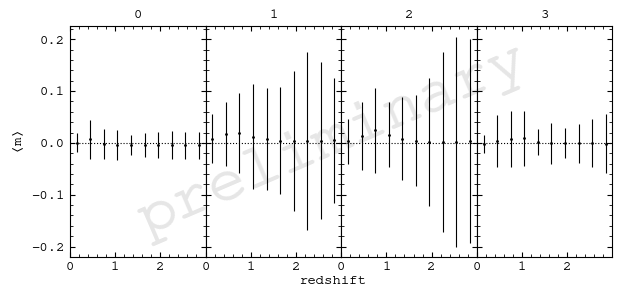

In [227]:
fig, axs = plt.subplots(1, 4, figsize=(7, 3), sharex=True, sharey="row")

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _mean_plus = np.nanmean(mean_m_plus[tomographic_bin], axis=0)
    _mean_minus = np.nanmean(mean_m_minus[tomographic_bin], axis=0)
    mean = 0.5 * (_mean_plus + _mean_minus)
    
    n_jackknife = None
    
    if n_jackknife is None:
        n_jackknife_1 = len(mean_m_plus[tomographic_bin])
        n_jackknife_2 = len(mean_m_minus[tomographic_bin])
        assert n_jackknife_1 == n_jackknife_2
        n_jackknife = n_jackknife_1
    
    _var_plus = (n_jackknife - 1) / n_jackknife * np.nansum(
        (mean_m_plus[tomographic_bin] - _mean_plus) * (mean_m_plus[tomographic_bin] - _mean_minus),
        axis=0,
    )
    _var_minus = (n_jackknife - 1) / n_jackknife * np.nansum(
        (mean_m_minus[tomographic_bin] - _mean_minus) * (mean_m_minus[tomographic_bin] - _mean_minus),
        axis=0,
    )
    var = 0.5 * (_var_plus + _var_minus)

    std = np.sqrt(var)
    
    axs[tomographic_bin].axhline(0, ls=":")
    axs[tomographic_bin].errorbar(centers, mean, std, fmt="o", c="k")

    axs[tomographic_bin].set_title(tomographic_bin)

fig.supxlabel("redshift")
axs[-1].set_xlim(0, 3)
axs[-1].set_xticks([0, 1, 2])
axs[0].set_ylabel("$〈m〉$")

lib.plotting.watermark(fig)

# fig.savefig("chromatic-bias.pdf")
plt.show()


In [141]:
# fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

# norm = mpl.colors.Normalize(vmin=0)
# cmap = "binary"

# shear_step = shear_step_plus
# with (
#     h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
#     h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
#     # h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
#     # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
# ):
#     flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
#     flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
#     color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

#     redshift = truth["mdet"]["noshear"]["z"][:]

#     axs.hist2d(
#         redshift,
#         color - lib.const.GI_COLOR,
#         bins=bins,
#         norm=norm,
#         cmap=cmap,
#     )

        
# fig.supxlabel("$z$")
# fig.supylabel("$(g - i) - med(g - i)$")


# plt.show()           

In [142]:
# fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

# norm = mpl.colors.Normalize(vmin=0)
# cmap = "binary"

# shear_step = shear_step_plus
# with (
#     h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step]) as shear,
#     h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step]) as truth,
#     h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step]) as tomo,
#     # h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step]) as weight,
# ):
#     flux_g = shear["mdet"]["noshear"]["pgauss_band_flux_g"][:]
#     flux_i = shear["mdet"]["noshear"]["pgauss_band_flux_i"][:]
#     color = lib.util.flux_to_mag(flux_g) - lib.util.flux_to_mag(flux_i)

#     redshift = truth["mdet"]["noshear"]["z"][:]

#     bhat = tomo["sompz"]["noshear"]["bhat"][:]


#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#         in_tomo = (bhat == tomographic_bin)

#         axs[tomographic_bin].hist2d(
#             redshift[in_tomo],
#             color[in_tomo] - lib.const.GI_COLOR,
#             bins=bins,
#             norm=norm,
#             cmap=cmap,
#         )

#         axs[tomographic_bin].text(
#             0.95, 0.95,
#             f"bin {tomographic_bin}",
#             ha="right",
#             va="top",
#             transform=axs[tomographic_bin].transAxes,
#         )
        
# fig.supxlabel("$z$")
# fig.supylabel("$(g - i) - med(g - i)$")

# fig.colorbar(
#     mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=axs.ravel(),
# )

# plt.show()           